# Synthea/CodeX Data EDA

___
Names: 
>Ali Raza Zaidi & Laiba Zaman

Dates: 
>January 13-17, 2022

Jira Ticket:
>DIG-759

Description:
>EDA of Synthea Data and Selection of Inputs and Outputs to Classifier

### Purpose
We will carry out an Exploratory Data Analysis (EDA) of the [Synthea Data](https://confluence.hl7.org/display/COD/mCODE+Test+Data) ingested into a local katsu environment and accessed through a local GraphQL API Service, as explained through the documentation of the [Federated Learning](https://github.com/CanDIG/federated-learning) and [GraphQL-interface](https://github.com/CanDIG/GraphQL-interface) projects.

The data processing and EDA work done here has been inspired by the work of [Rishabh Sambare](https://github.com/CanDIG/federated-learning/blob/main/examples/synthea-breast-cancer/EDA.ipynb) with his EDA on the Synthea Data.

We will access the data through the local GraphQL API, hosted locally on the 7999 port. The data processing performed in this EDA will come in handy when training our classifier, which will be done in another Jupyter Notebook.

#### Importing Requirements

In [1]:
from parsers import PatientInfoParser, UniqueInfoParser # Used to parse information from patients
import requests # Used to access the API for the data
import pandas as pd # Used to cleanup and organize the data
import seaborn as sns # Used for data visualization
import matplotlib.pyplot as plt # used for data visualization
from defaults import DEFAULT_QUERY # Used to collect query information

#### Initializing & Executing Query

In [2]:
host = 'http://localhost' 
dataset_graphql_url = f'{host}:7999/graphql'

We will not be accessing the following pieces of information from the data due to various reasons. A sample of the dropped data are below. Note some possible MCode fields (Eg. karyotypic sex) are not included here since the Synthea Data did not include them at all

Dropped Data:
- All id / alternate id's: 
    Useless for our purposes
- All 'created' and 'updated' data fields: 
    Useless for our purposes
- 'table' alphanumeric code data: 
    Useless for our purposes
- cancer_condition alphanumeric code data: 
    Useless for our purposes
- condition_type: 
    Useless for our purposes since all were primary
- verfication_status: 
    Useless for our purposes since all were confirmed
- clinical_status: 
    Useless for our purposes since all breast cance cases were active
- cancer_procedure code labels: 
    As Rishabh noted in his EDA Jira Ticket, the data was quite sparse to analyze by 
    specific procedure type so instead we simply analyzed by # of procedures(surgical or radiation)
- cancer_procedures extra properties: 
    Useless for our purposes since it simply had time of operation
- cancer_procedure reason reference alphanumeric code: 
    Useless for our purposes
- genomicsReport: 
    null data
- tnmType: 
    all of the types were clinical TNM's so useless for our purpose
- metastasesCategory:
    The data seemed to indicate the wrong group types (N0, N1, N2, etc.) instead of the required M0 & M1 per the [NCBI](https://www.ncbi.nlm.nih.gov/books/NBK553187/#:~:text=T%20%2D%20Tumor.&text=For%20example%2C%20T1%20indicates%20invasion,an%20invasion%20into%20the%20subserosa.) so these categories were dropped

The Query with all of the required fields is present in the [defaults file](defaults.py).

In [3]:
data_json = requests.post(dataset_graphql_url, json={'query': DEFAULT_QUERY})
data_json.status_code

200

#### Collecting Patient Data

In [4]:
patient_info_json = data_json.json().get('data').get('katsuDataModels').get('mcodeDataModels').get('mcodePackets')

In [5]:
patient_info_json[1] # Example Data

{'subject': {'dateOfBirth': '1941-12-25', 'sex': 'FEMALE'},
 'cancerCondition': [{'dateOfDiagnosis': '2009-12-08T12:25:14Z',
   'tnmStaging': None,
   'code': {'label': 'Malignant neoplasm of breast (disorder)'}}],
 'cancerRelatedProcedures': [],
 'cancerDiseaseStatus': {'label': "Patient's condition improved"},
 'medicationStatement': []}

#### Parsing Patient Information

In [6]:
'''Defining the unique medications and procedure types'''
uniq_finder = UniqueInfoParser(patient_info_json)

uniq_meds = uniq_finder.get_uniq_meds()
uniq_procedures = uniq_finder.get_uniq_procedures()

In [7]:
patient_info_list = []
for patient in patient_info_json:
    patient_info_dict = {}
    patient_info = PatientInfoParser(uniq_meds, uniq_procedures, patient).get_patient_data()
    
    number_of_meds = sum([quantity for quantity in patient_info.meds.values()])
    
    for procedure in uniq_procedures:
        patient_info_dict[procedure] = patient_info.procedures[procedure]
    
    patient_info_dict['sex'] = patient_info.sex
    patient_info_dict['nodes'] = patient_info.nodes
    patient_info_dict['stage'] = patient_info.stage
    patient_info_dict['numberOfMeds'] = number_of_meds
    patient_info_dict['primary'] = patient_info.primary
    patient_info_dict['diagnosisAge'] = patient_info.age
    patient_info_dict['cancerType'] = patient_info.cancer_type
    patient_info_dict['cancerStatus'] = patient_info.cancer_status
    patient_info_list.append(patient_info_dict)

#### Cleaning collected data and creating DataFrame

In [8]:
pd.set_option('display.max_columns', None)

df = pd.DataFrame(patient_info_list)
df = df.dropna(subset=['numberOfMeds', 'nodes', 'primary', 'stage', 'sex', 'diagnosisAge', 'cancerStatus'])
df = df.loc[df['sex'] != 0]
df = df.loc[df['cancerType'] == 'Malignant neoplasm of breast (disorder)']
df = df.drop(columns=['cancerType', 'sex'])
df = df.reset_index(drop=True)

In [9]:
df

,surgical,radiation,nodes,stage,numberOfMeds,primary,diagnosisAge,cancerStatus
0,1,34,0.0,1.0,2,1.0,51.967146,1.0
1,1,0,0.0,2.0,11,2.0,43.972621,1.0
2,1,34,0.0,2.0,3,2.0,26.981520,1.0
3,1,34,0.0,1.0,2,1.0,61.957563,1.0
4,3,0,3.0,4.0,14,4.0,59.961670,1.0
...,...,...,...,...,...,...,...,...
1338,2,0,1.0,2.0,10,2.0,4.999316,1.0
1339,1,0,0.0,2.0,10,3.0,65.954825,1.0
1340,1,34,0.0,2.0,2,2.0,67.953457,1.0
1341,1,34,0.0,1.0,16,1.0,62.959617,1.0


#### Data Evaluation

In [10]:
corr = df.corr()

In [11]:
corr

,surgical,radiation,nodes,stage,numberOfMeds,primary,diagnosisAge,cancerStatus
surgical,1.000000,-0.062704,0.761003,0.647574,0.330907,0.408530,-0.004723,-0.163495
radiation,-0.062704,1.000000,-0.100313,-0.114890,-0.525931,-0.090874,0.047586,0.046999
nodes,0.761003,-0.100313,1.000000,0.797116,0.470934,0.432325,-0.035044,-0.205761
stage,0.647574,-0.114890,0.797116,1.000000,0.486670,0.786066,-0.009954,-0.275022
numberOfMeds,0.330907,-0.525931,0.470934,0.486670,1.000000,0.337412,-0.025874,-0.163081
primary,0.408530,-0.090874,0.432325,0.786066,0.337412,1.000000,-0.012183,-0.223592
diagnosisAge,-0.004723,0.047586,-0.035044,-0.009954,-0.025874,-0.012183,1.000000,0.006377
cancerStatus,-0.163495,0.046999,-0.205761,-0.275022,-0.163081,-0.223592,0.006377,1.000000


<AxesSubplot:>

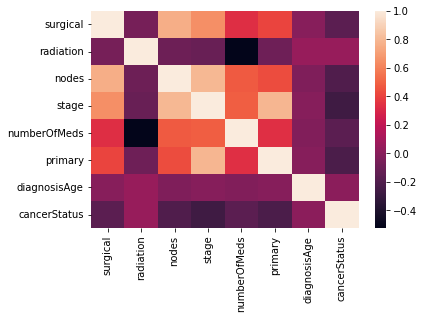

In [12]:
sns.heatmap(corr)

We can see that most of the fields don't seem to be correlated with the others, however, the *stage* category does seem to be slightly different, hence why we will try to use this header as the output for our classifier

___
In the end, we find that a suitable list of inputs for our classifiers can be:
- surgical: Number of surgeries performed on the patient
    - int between \[0 .. \*\]
- radiation: Number of radiation therapy sessions performed on the patient
    - int between \[0 .. \*\]
- cancerStatus: Whether or not the patient's condition improved
    - int between \[0 .. 1\]
- diagnosisAge: At what age the person was diagnosed with cancer
    - float between \[0.0 .. \*\]
- primary: The patient's primary tumour category
    - int between \[0 .. 4\]
- nodes: The patient's regional node category
    - int between \[0 .. 3\]
- numberOfMeds: The number of medications given to the patient
    - int between \[0 .. \*\]

The output we determined to be optimal for our analysis was:
- stage: The clinical cancer stage of the patient
    - int between \[0 .. 4\]

Finally, we now decide on what classifier to use on our data. We took a look at several different classifiers, from Support Vector Classifiers (SVC) to Naive Bayesian Classifiers. We ended up choosing our default classifier to be the Decision Tree Classifier, although we were quite interested in the Random Forest, KNN, Support Vector and Naive-Bayesian classifiers as alternative options. We chose to do this because Decision Trees are [easy to interpret, require minimal processing and are robust](https://towardsdatascience.com/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b60575#:~:text=Even%20though%20Decision%20trees%20is,all%20types%20of%20data%20nicely.)

#### Data Persistence

In [13]:
df.to_csv(path_or_buf='SyntheaEDA.csv', index=False)